In [9]:
import pandas as pd
import numpy as np
import shap
import joblib
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [10]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, drop_first=True)

if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

/tmp/ipykernel_14925/1650335439.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\nModel: {name}")
    print(classification_report(y_test, preds))
    print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)
print("\nBest Params:", grid.best_params_)

joblib.dump(grid.best_estimator_, "best_model.pkl")



Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1036
           1       0.64      0.68      0.66       373

    accuracy                           0.81      1409
   macro avg       0.76      0.77      0.76      1409
weighted avg       0.82      0.81      0.81      1409

ROC-AUC Score: 0.855825664806898

Model: Random Forest
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1036
           1       0.70      0.46      0.56       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.81      0.79      1409

ROC-AUC Score: 0.8524459925264214


/home/yussuf/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model: XGBoost
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.50      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC Score: 0.8391770265094662

Best Params: {'max_depth': 8, 'n_estimators': 200}


['best_model.pkl']

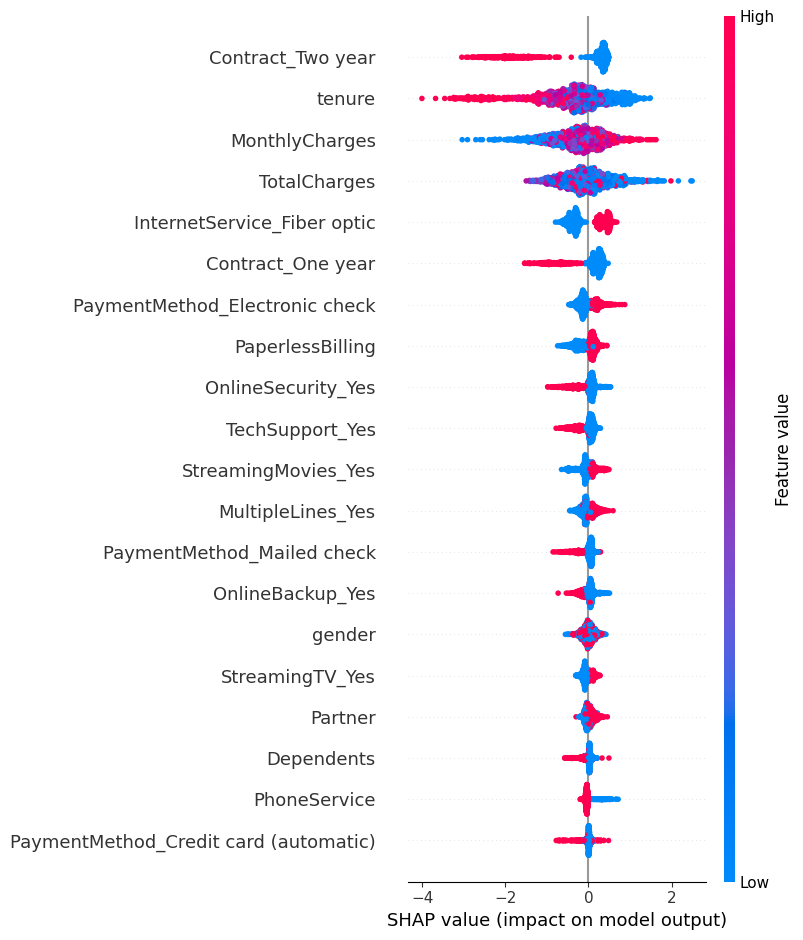

2025/07/18 17:44:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/18 17:44:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model logged to MLflow.


In [14]:
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)


mlflow.set_experiment("Telco Churn Prediction")

with mlflow.start_run():
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1]))
    mlflow.sklearn.log_model(grid.best_estimator_, "model")
    print("\nModel logged to MLflow.")
